# Import des modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Modules pour le machine learning et le preprocessing

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score

from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")


# Importation du jeu de données

In [3]:
df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/rains.csv', index_col=[1,0])

df.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
Location  Date                                                            
Newcastle 2008-12-01     13.2      NaN       0.0          NaN       NaN   
          2008-12-02      NaN     32.2       0.0          NaN       NaN   
          2008-12-03     16.2     32.2       0.0          NaN       NaN   
          2008-12-04     19.2     24.0       0.0          NaN       NaN   
          2008-12-05     18.8     30.2       0.0          NaN       NaN   

                     WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
Location  Date                                                          
Newcastle 2008-12-01         NaN            NaN         NW         NW   
          2008-12-02         NaN            NaN        NaN         NE   
          2008-12-03         NaN            NaN          N         SE   
          2008-12-04         NaN            NaN         SE         SE   
          2008-12-05         NaN            NaN         NE        NaN   

                      WindSpeed9am  ...  Humidity9am  Humidity3pm  \
Location  Date                      ...                             
Newcastle 2008-12-01           6.0  ...         50.0         24.0   
          2008-12-02           NaN  ...          NaN         59.0   
          2008-12-03           2.0  ...         74.0         26.0   
          2008-12-04          22.0  ...         66.0         61.0   
          2008-12-05           4.0  ...         85.0          NaN   

                      Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
Location  Date                                                                
Newcastle 2008-12-01          NaN          NaN       3.0       4.0     21.8   
          2008-12-02          NaN          NaN       NaN       0.0      NaN   
          2008-12-03          NaN          NaN       4.0       4.0     22.2   
          2008-12-04          NaN          NaN       7.0       5.0     20.4   
          2008-12-05          NaN          NaN       8.0       NaN     20.0   

                      Temp3pm  RainToday RainTomorrow  
Location  Date                                         
Newcastle 2008-12-01     30.6         No           No  
          2008-12-02     25.4         No           No  
          2008-12-03     32.0         No           No  
          2008-12-04     23.0         No           No  
          2008-12-05      NaN         No           No  

[5 rows x 21 columns]

In [4]:
print(df.shape)
print(df.index.get_level_values(0).unique().tolist())
print(df.index.get_level_values(1).min(), '->' , df.index.get_level_values(1).max())

(25631, 21)
['Newcastle', 'Sydney', 'Canberra', 'Melbourne', 'Brisbane', 'GoldCoast', 'Adelaide', 'Perth']
2007-11-01 -> 2017-06-25


Le jeux de données contient **25 631** observations constituées de **21** colonnes concernant **8** villes australiennes du 2007 au 2017.

La variable cible est *RainTomorrow*. Il s'agît d'une variable discrète qui peut prendre 2 valeurs (Yes/No) : le problème est donc un problème de **classification binaire**. 

Des 20 features, 17 sont des variables quantitatives et 3 qualitatives (*WindGustDir*, *WindDir9am*, *WindDir3pm*).

# Préparation des données

In [5]:
df.isna().any(axis=1).sum() / len(df)

0.5847216261558269

**58%** des observations contiennent au moins une valeure manquantes !

In [6]:
print(df["RainTomorrow"].isna().sum())
df = df[-df["RainTomorrow"].isna()]

1062


**1062** observations n'ont pas de valeur pour la variable cible. Nous commençon par eliminer ces observations.

Observons maintenant quelles est la distribution des valeurs manquantes par variable.

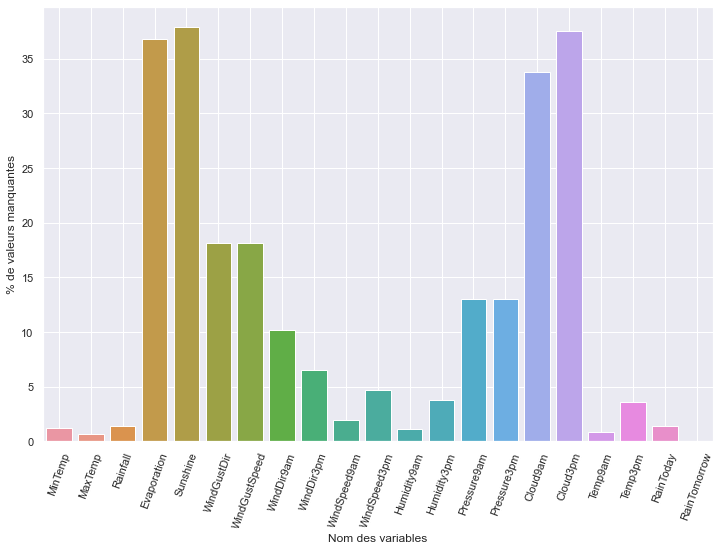

In [7]:
sns.set_theme()
plt.figure(figsize=(12,8))
b = sns.barplot(x=df.columns, y=df.isna().sum() / len(df) * 100)
b.set_xticklabels(b.get_xticklabels(), rotation=70)
b.set_xlabel("Nom des variables")
b.set_ylabel("% de valeurs manquantes")
b.xaxis.grid(True);

Nous pouvons voir qu'il y a 4 variables qui sont absentes dans plus d'un tiers des observations : *Evaporation*, *Sunshine*, *Cloud9am* et *Cloud3pm*.

Observons la distribution de leur absence par ville.

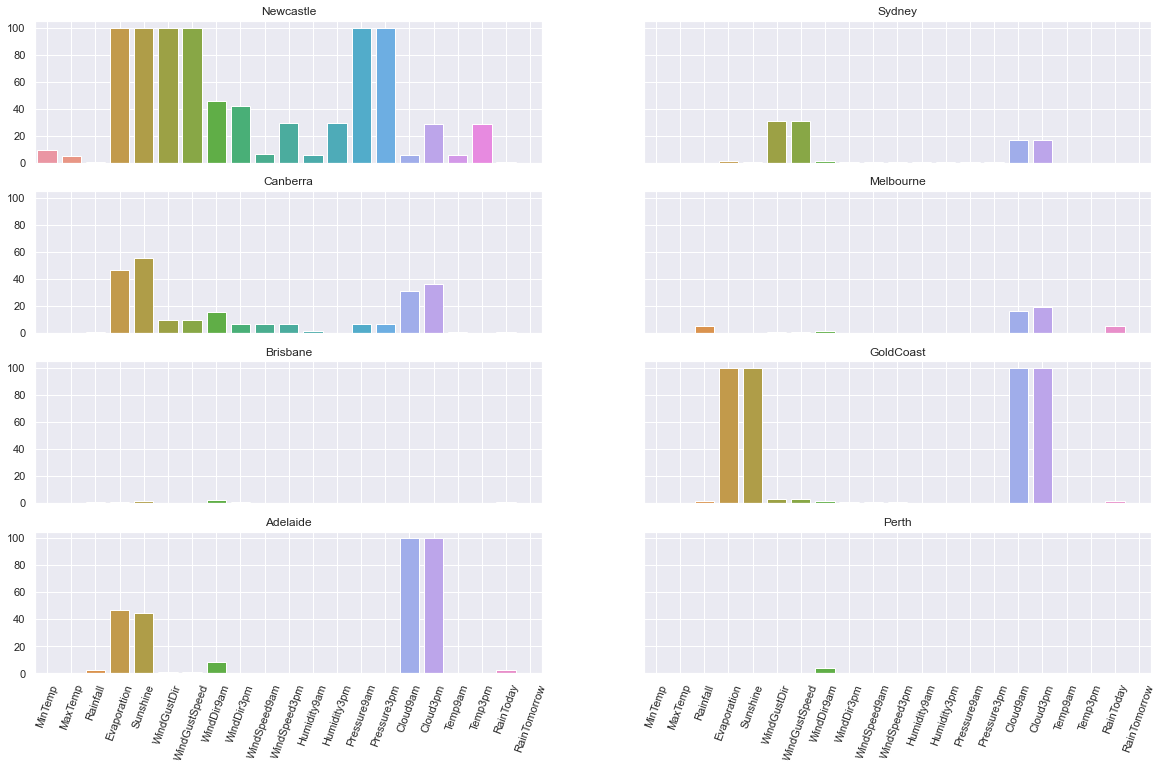

In [8]:
fig, ax = plt.subplots(4,2, sharex=True, sharey=True, figsize=(20,12))

for i, location in enumerate(df.index.get_level_values(0).unique()):
    sns.set_theme()
    b = sns.barplot(x=df.columns, y=df.loc[location].isna().sum() / len(df.loc[location]) * 100, ax=ax[int(i/2),i%2])
    b.set_xticklabels(b.get_xticklabels(), rotation=70)
    b.set_title(location)
    b.xaxis.grid(True)


On peut observer que, pour les villes de Newcastle et Perth il n'y a pas du tout de données concernant ces 4 variables. Il paraît donc difficile de reconstruire leur valeur sur la base d'une interpolation ou d'une valeur moyenne. Nous décidons par conséquent d'éliminer ces 4 variables du jeu de données.

In [9]:
df = df.drop(["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"], axis=1)
df.shape

(24569, 17)

Nous avons maintenant un jeu de 24 569 observations avec encore des Nans. Nous décidons de remplacer ces valeurs par une interpolation temporelle ville par ville. 

Cependant, avant, il est nécessaire avant de transformer les variables qualitatives en valeurs quantitatives.

In [10]:
dict_val = {
    'N'     : 0,
    'NNE'   : 22.5,
    'NE'    : 45,
    'ENE'   : 67.5,
    'E'     : 90,
    'ESE'   : 112.5,
    'SE'    : 135,
    'SSE'   : 157.5,
    'S'     : 180,
    'SSW'   : 202.5,
    'SW'    : 225,
    'WSW'   : 247.5,
    'W'     : 270,
    'WNW'	: 292.5,
    'NW'	: 315,
    'NNW'	: 337.5,
    'N'	    : 360,

    'Yes'   : 1,
    'No'    : 0
}

df = df.replace(dict_val)

In [11]:
new_df = pd.DataFrame()
for location in df.index.get_level_values(0).unique():
    df_location = df.loc[location]
    df_location.index = pd.DatetimeIndex(df_location.index)
    df_location = df_location.interpolate(method='time').dropna().reset_index() #Drop first line, if first line is a Nan
    df_location['Location'] = location
    new_df = pd.concat([new_df, df_location])

df = new_df.set_index(['Location', 'Date'])
df.shape

(20635, 17)

Pour terminer la préparation des données, nous ajoutons une variable raprésentant le mois de l'observation, qui a une influence sur la variable cible.

In [12]:
df['Month'] = df.index.get_level_values(1).month
df.shape

(20635, 18)

Nous avons maintenant un jeu de données propre composé de **20 635** observations et **18** variables. 

Nous séparons le jeu de données en variable explicative **X** et variable cible **y**

In [13]:
X = df.drop(columns="RainTomorrow")
y = df['RainTomorrow']

# Modélisation

Nous allons comparer dans cette partie la performance de différents modèles de classification binaire, en faisant varier leurs hyperparamètres (**hyperparameter tuning**).

Pour cela, nous utilisons la fonction **GridSearchCV** de Scikit Learn.

In [14]:
def models_accuracy(X, y, sampler, models, params):
    """Function to find the better model and the best parameters."""
    resample = sampler
    X_res, y_res = resample.fit_resample(X, y)
    X_train,  X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

    # Creation of a pipeline to scale the values and apply the model.
    pipe = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                           ('m', models)])

    # Tool to find the best parameters for a model.
    grid = GridSearchCV(pipe, 
                        param_grid=params, 
                        scoring=["accuracy", "balanced_accuracy"], 
                        n_jobs=2,
                        refit="balanced_accuracy",
                        verbose=0)

    # Training.
    grid.fit(X_train, y_train)
    accuracy_train = np.median([x for x in grid.cv_results_["mean_test_accuracy"] if pd.isnull(x) == False])
    balanced_accuracy_train = np.median([x for x in grid.cv_results_["mean_test_balanced_accuracy"] if pd.isnull(x) == False])

    # Test.
    grid_predict = grid.predict(X_test)
    accuracy_test = accuracy_score(y_test, grid_predict)
    balanced_accuracy_test = balanced_accuracy_score(y_test, grid_predict)

    # Resultat with the best parameters and the accuracy score 
    # and balanced accuracy score for both training and test
    result = (grid.best_params_, accuracy_train, balanced_accuracy_train,
    accuracy_test, balanced_accuracy_test, pd.crosstab(y_test, grid_predict))

    return result
    

Nous avons selectionné 5 modèles de classification à comparer :
- Arbre de décision
- Gradient Boosting
- Classificateur bayesien 
- Régression logistique
- KNN

In [15]:
models_to_compare = {
    'Decision Tree Classifier' : DecisionTreeClassifier(class_weight="balanced"), 
    'Gradient Boosting Classifier' : GradientBoostingClassifier(),
    'Gaussian NB' : GaussianNB(),
    'Logistic Regression' : LogisticRegression(max_iter=10000, n_jobs=1, class_weight="balanced"),
    'KNN' : KNeighborsClassifier(n_jobs=1)
}

Pour chaque modèle, nous avons défini une combinaison d'hyperparamètres à faire tester par GridSearchCV

In [16]:
params_for_models = [
        [{"m__criterion": ["gini", "entropy"],
        "m__splitter": ["best", "random"],
        "m__min_samples_split": np.arange(2, 6),
        "m__min_samples_leaf": np.arange(2, 6)
        }],
        [{"m__loss": ["deviance", "exponential"],
        "m__learning_rate": np.arange(0.1, 0.5, 0.1),
        "m__n_estimators": np.arange(100, 160, 10),
        }],
        [{                    
        }],   
        [{"m__penalty": ["l1", "l2", "elasticnet", "none"],
        "m__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}],
        [{"m__n_neighbors": np.arange(5, 10),
        "m__weights": ["uniform", "distance"],
        "m__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        }]
]


Nous vérifions si le jeux de données est équilibré :

In [17]:
y.value_counts(normalize=True)

0    0.772619
1    0.227381
Name: RainTomorrow, dtype: float64

On peut voir qu'il y a beaucoup plus de jours sans pluie que des jours avec pluie. 

Pour compenser ce désequilibre, nous allons tester différents méthodes d'over-sampling et under-sampling :

In [18]:
samplers_to_compare = {
    "Random Over Sampler": RandomOverSampler(),
    "SMOTE": SMOTE(random_state=42),
    "Random Under Sampler": RandomUnderSampler(),
    "Cluster Centroids": ClusterCentroids(),
    "SMOTEENN": SMOTEENN()
}

## Recherche du modèle plus performant avec la méthode **RandomOverSampling**

In [19]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Random Over Sampler":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n\n')
    

Modèle: Decision Tree Classifier - sampler: Random Over Sampler
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 2, 'm__min_samples_split': 3, 'm__splitter': 'best'}
Accuracy (train) : 0.8281362007168458
Balanced accuracy (train) : 0.8280409995796125
Accuracy (test) : 0.8754965502822496
Balanced accuracy (test) : 0.8758739743166866
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4067   768
1              423  4308


Modèle: Gradient Boosting Classifier - sampler: Random Over Sampler
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 150}
Accuracy (train) : 0.8137768817204301
Balanced accuracy (train) : 0.8138367426792368
Accuracy (test) : 0.8316955885427556
Balanced accuracy (test) : 0.831784810826608
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             3982   853
1              757  3974


Modèle: Gaussian NB - sampler: Random Over Sampler
Meilleurs

Le modèle ayant le meilleur résultat avec le **RandomOverSampling** est la méthode des `K Nearest Neighboors` avec  comme paramètres :

`{'m__algorithm': 'auto', 'm__n_neighbors': 8, 'm__weights': 'distance'}`

Balanced accuracy (train) : **83%**  
Balanced accuracy (test) : **88%**

## Recherche du modèle plus performant avec la méthode **SMOTE**

In [20]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "SMOTE":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: SMOTE
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 2, 'm__min_samples_split': 2, 'm__splitter': 'best'}
Accuracy (train) : 0.8059587813620072
Balanced accuracy (train) : 0.8060035538455497
Accuracy (test) : 0.8282458707923898
Balanced accuracy (test) : 0.8282130645261063
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4019   816
1              827  3904

Modèle: Gradient Boosting Classifier - sampler: SMOTE
Meilleurs paramètres : {'m__learning_rate': 0.30000000000000004, 'm__loss': 'deviance', 'm__n_estimators': 150}
Accuracy (train) : 0.8900089605734767
Balanced accuracy (train) : 0.8900996160973054
Accuracy (test) : 0.8966130043905499
Balanced accuracy (test) : 0.8963632246287714
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4445   390
1              599  4132

Modèle: Gaussian NB - sampler: SMOTE
Meilleurs paramètres : {}
Accuracy (

Le modèle ayant le meilleur résultat avec le **SMOTE** est la méthode du `Gradient Boosting` avec les paramètres suivants :

`{'m__learning_rate': 0.30000000000000004, 'm__loss': 'deviance', 'm__n_estimators': 150}`

Balanced accuracy (train) : **89%**  
Balanced accuracy (test) : **90%**

## Recherche du modèle plus performant avec la méthode **RandomUnderSampling**

In [21]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Random Under Sampler":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: Random Under Sampler
Meilleurs paramètres : {'m__criterion': 'gini', 'm__min_samples_leaf': 5, 'm__min_samples_split': 2, 'm__splitter': 'random'}
Accuracy (train) : 0.703636448997903
Balanced accuracy (train) : 0.7036626478761228
Accuracy (test) : 0.7137784090909091
Balanced accuracy (test) : 0.7136607258168668
Matrice de confusion :
col_0            0    1
RainTomorrow           
0             1031  393
1              413  979

Modèle: Gradient Boosting Classifier - sampler: Random Under Sampler
Meilleurs paramètres : {'m__learning_rate': 0.2, 'm__loss': 'exponential', 'm__n_estimators': 100}
Accuracy (train) : 0.7824286696319789
Balanced accuracy (train) : 0.7825239415950249
Accuracy (test) : 0.7915482954545454
Balanced accuracy (test) : 0.7912348250032287
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1166   258
1              329  1063

Modèle: Gaussian NB - sampler: Random Under Sampler
Meilleurs 

Le modèle ayant le meilleur résultat avec le **RandomUnderSampling** est la méthode du `Gradient Boosting` avec les paramètres suivantes :  

`{'m__learning_rate': 0.2, 'm__loss': 'exponential', 'm__n_estimators': 100}`

Balanced accuracy (train) : **79%**  
Balanced accuracy (test) : **79%**

## Recherche du modèle plus performant avec la méthode **ClusterCentroids**

In [22]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Cluster Centroids":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: Cluster Centroids
Meilleurs paramètres : {'m__criterion': 'gini', 'm__min_samples_leaf': 5, 'm__min_samples_split': 4, 'm__splitter': 'random'}
Accuracy (train) : 0.7687254025718695
Balanced accuracy (train) : 0.7687698901287912
Accuracy (test) : 0.7755681818181818
Balanced accuracy (test) : 0.7756279865685134
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1097   327
1              305  1087

Modèle: Gradient Boosting Classifier - sampler: Cluster Centroids
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'exponential', 'm__n_estimators': 140}
Accuracy (train) : 0.8625154032790001
Balanced accuracy (train) : 0.8624102014568036
Accuracy (test) : 0.8661221590909091
Balanced accuracy (test) : 0.8664237052821904
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1196   228
1              149  1243

Modèle: Gaussian NB - sampler: Cluster Centroids
Meilleurs para

Le modèle ayant le meilleur résultat avec le **ClusterCentroids** est la méthode du `Gradient Boosting` avec les paramètres suivants :  

`{'m__learning_rate': 0.4, 'm__loss': 'exponential', 'm__n_estimators': 120}`

Balanced accuracy (train) : **86%**  

Balanced accuracy (test) : **86%**

## Recherche du modèle plus performant avec la méthode **SMOTEENN** (combine Over-sampling et Under-sampling)

In [23]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "SMOTEENN":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: SMOTEENN
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 2, 'm__min_samples_split': 5, 'm__splitter': 'best'}
Accuracy (train) : 0.8764023146606699
Balanced accuracy (train) : 0.8749958866967382
Accuracy (test) : 0.8836194764987335
Balanced accuracy (test) : 0.8817215422935942
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             2615   393
1              434  3664

Modèle: Gradient Boosting Classifier - sampler: SMOTEENN
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'exponential', 'm__n_estimators': 150}
Accuracy (train) : 0.932040630722418
Balanced accuracy (train) : 0.9313189638005559
Accuracy (test) : 0.9448179271708683
Balanced accuracy (test) : 0.9440721133016033
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             2831   183
1              211  3915

Modèle: Gaussian NB - sampler: SMOTEENN
Meilleurs paramètres : {}
Accuracy (train

Le modèle ayant le meilleur résultat avec le **SMOTEENN** est la méthode du `Gradient Boosting` :  

`{'m__algorithm': 'auto', 'm__n_neighbors': 6, 'm__weights': 'distance'}`

Balanced accuracy (train) : **91%**  

Balanced accuracy (test) : **93%** 

## Au vue des résultat nous pouvons choisir le modèle de `GradientBoostingClassifier` avec un reéchantillonage avec la méthode du `SMOTEENN`.  
## Cela permet d'avoir un résulatat juste à plus de 93%. 

